In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import cv2

In [2]:
import tensorflow_hub as hub

#특징 추출기 불러오기( 완전연결계층 X / input_shape 또한 따로 특정되지 않음 / 사전 훈련 x )
res_url = 'https://tfhub.dev/tensorflow/resnet_50/feature_vector/1'
feature_model = tf.keras.Sequential([
    hub.KerasLayer(res_url, 
                   output_shape=(2048,), 
                   trainable=False)
])
feature_model.build([None, 224, 224, 3])
feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23561152  
Total params: 23,561,152
Trainable params: 0
Non-trainable params: 23,561,152
_________________________________________________________________


In [3]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 224
batch_size = 32

# 학습 및 검증 데이터용 ImageDataGenerator 생성해 놓기 
train_datagen = ImageDataGenerator(rescale=1./255., 
                                   horizontal_flip = True, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   validation_split = 0.25)

#검증데이터는 정규화 외에 따로 조정 없음 
valid_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.25)

#flow_from_directory()는 앞서 배운 flow()와 비슷, 단 경로를 통채로 가져올 수 있음 
train_generator = train_datagen.flow_from_directory(directory = '/content/drive/My Drive/AI_SCHOOL/covid data/Data/train', #저장 경로 
                                                    subset = 'training',   
                                                    batch_size = batch_size,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

valid_generator = valid_datagen.flow_from_directory(directory = '/content/drive/My Drive/AI_SCHOOL/covid data/Data/train',
                                                    subset = 'validation',
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))


Found 3859 images belonging to 3 classes.
Found 1285 images belonging to 3 classes.


In [ ]:
# 학습데이터의 3배정도 이미지가 보강되도록 한다.
import numpy as np

image_size = 224
batch_size = 32

batch_step = (3859 * 3) // batch_size #데이터 증폭 시켜 배치 스텝을 구해준다.(120회)
train_features = [] # 빈 리스트 생성 
train_Y = [] # 빈 리스트 생성 

for idx in range(batch_step): #스텝 만큼 반복
  if idx % 10 == 0: #만약 0 포함 100의 배수일때
    print(idx) #배치스텝 반환 (진행상황 표기)
  x, y = train_generator.next() #next()를 활용하여 train_generator에 담겨진 [[입력픽셀],[라벨링]] 을 x와 y에 담아 준다. 
  train_Y.extend(y) #append()와 비슷한 기능, list에 appending 수행
  
  # feature_model : 이미 학습이 완료된 특징 추출기 (우리가 불러옴)
  # 학습데이터 x 를 활용해서 feature_model을 통과시켜 특징 추출.
  feature = feature_model.predict(x)
  train_features.extend(feature)

#array 전환 
train_features = np.array(train_features)
train_Y = np.array(train_Y)

print(train_features.shape)
print(train_Y.shape)

0
10
20
30
40


In [ ]:
valid_features = [] # 빈 리스트 생성 
valid_Y = [] # 빈 리스트 생성 

for idx in range(valid_generator.n): ## valid_generator.n = 1285 (검증데이터의 수)
  if idx % 100 == 0: #만약 0 포함 100의 배수일때
    print(idx) #배치스텝 반환 (진행상황 표기)
  x, y = valid_generator.next() #next()를 활용하여 valid_generator에 담겨진 [[입력픽셀],[라벨링]] 을 x와 y에 담아 준다.   
  valid_Y.extend(y) #append()와 비슷한 기능, list에 appending 수행
  
  # feature_model : 이미 학습이 완료된 특징 추출기 (우리가 불러옴)
  # 학습데이터 x 를 활용해서 feature_model을 통과시켜 특징 추출.
  feature = feature_model.predict(x)
  valid_features.extend(feature)

#array 전환 
valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)

print(valid_features.shape)
print(valid_Y.shape)

In [54]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(256, activation= 'relu', input_shape = (2048,)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(3,activation='softmax')
])
model.compile(tf.optimizers.RMSprop(0.0001), 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 525,315
Trainable params: 525,315
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(train_features, train_Y, 
                    validation_data=(valid_features, valid_Y),
                    epochs = 30,
                    batch_size = 32)

Epoch 1/30
361/361 [==============================] - 1s 3ms/step - loss: 0.3172 - accuracy: 0.8708 - val_loss: 0.1738 - val_accuracy: 0.9447
Epoch 2/30
361/361 [==============================] - 1s 3ms/step - loss: 0.1835 - accuracy: 0.9268 - val_loss: 0.1398 - val_accuracy: 0.9572
Epoch 3/30
361/361 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.9364 - val_loss: 0.1752 - val_accuracy: 0.9409
Epoch 4/30
361/361 [==============================] - 1s 3ms/step - loss: 0.1406 - accuracy: 0.9459 - val_loss: 0.1524 - val_accuracy: 0.9502
Epoch 5/30
361/361 [==============================] - 1s 3ms/step - loss: 0.1325 - accuracy: 0.9492 - val_loss: 0.1730 - val_accuracy: 0.9440
Epoch 6/30
361/361 [==============================] - 1s 3ms/step - loss: 0.1217 - accuracy: 0.9545 - val_loss: 0.1240 - val_accuracy: 0.9580
Epoch 7/30
361/361 [==============================] - 1s 3ms/step - loss: 0.1135 - accuracy: 0.9570 - val_loss: 0.1286 - val_accuracy: 0.9564
Epoch 

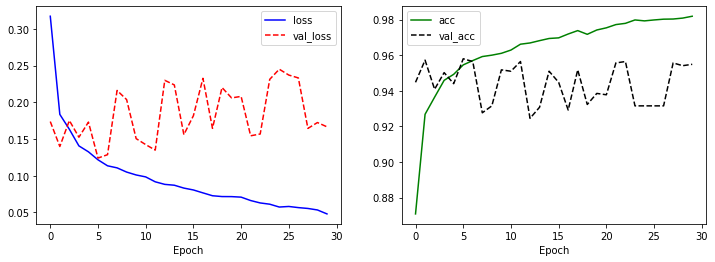

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
 
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label = 'acc')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [59]:
results = model.evaluate(valid_features, valid_Y)
print('Test accuracy: ', results[1])

41/41 [==============================] - 0s 2ms/step - loss: 0.1666 - accuracy: 0.9549
Test accuracy:  0.9548637866973877


In [60]:
model.save('/content/drive/My Drive/Resnet_model_final.h5')

In [ ]:
from keras.models import load_model
# 모델 불러오기
# 모델 불러올 때 Warning이 표시되는데 이는 더 training하지 못한다는 의미이고,
# 이 함수에서는 더 이상 training을 하지 않음.
model = load_model('/content/drive/My Drive/my_model.h5')
# feature_model = load_model(feature_model_path, custom_objects={'KerasLayer': hub.KerasLayer})

# 이미지를 불러옴
# img_path= '/content/drive/My Drive/covid/Data/test/NORMAL/NORMAL(10).jpg'
img = cv2.imread('/content/drive/My Drive/AI_SCHOOL/train/COVID-19/COVID-19 (100).png')
# 이미지 크기를 모델에 맞게 조정
img = cv2.resize(img, dsize=(224,224))
# 이미지 픽셀값 스케일링
img = img / 255.0
# 이미지 차원 확장 (224,224,3) -> (1,224,224,3)  : feature_model에 넣기위함
img = np.expand_dims(img, axis=0)
# feature_model에서 feature 추출
feature_vector = feature_model.predict(img)
# 앞서 생성한 model 분류기를 통해 예측 수행
prediction = model.predict(feature_vector)[0]

unique_sorted_Y = ['COVID19','NORMAL','PNEUMONIA']
#확률의 예측값을 5개 선출 
#[::-1] Extended Slices 기법으로 내림차순으로 변경
top_3_predict = prediction.argsort()[::-1]

# labels에 저장 
labels = [unique_sorted_Y[index] for index in top_3_predict]
print(labels[0])

COVID19


In [ ]:
함수만들어서 모델이랑 슬랙

In [35]:
from keras.models import load_model

def prediction(yourmodel,image,res_url):
    model = load_model(yourmodel)
    img = cv2.imread(image)
    img = cv2.resize(img, dsize=(224,224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    feature_model = tf.keras.Sequential([
    hub.KerasLayer(res_url, 
                   output_shape=(2048,), 
                   trainable=False)])
    feature_vector = feature_model.predict(img)
    prediction = model.predict(feature_vector)[0]
    unique_sorted_Y = ['COVID19','NORMAL','PNEUMONIA']
    top_3_predict = prediction.argsort()[::-1]
    labels = [unique_sorted_Y[index] for index in top_3_predict]
    print(labels[0])

In [34]:
prediction('/content/drive/My Drive/my_model1.h5','/content/drive/My Drive/AI_SCHOOL/covid data/Data/test/PNEUMONIA/PNEUMONIA(1092).jpg')

PNEUMONIA


In [ ]:
# 오차 행렬
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_lr)
print("오차 행렬:\n", confusion)